In [2]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

%autosave 120

Autosaving every 120 seconds


In [4]:
import sys
# sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip
import pandas as pd

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer, LlamaTokenizer
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
torch.set_grad_enabled(False);

There was a problem when trying to write in your cache folder (/raid3/xd/.cache/torch/hub). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.


In [13]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# HD = 64; M = 16; I = 2; D = 2048
HD = 128; M = 32; I = 2; D = 2560 # 4096
# HD = 96; M = 24; I = 2; D = 1536
math.sqrt(1 / HD) * 2 / (M + I) * 0.01
math.sqrt(2 / (D + M)) * 0.005

In [5]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _str, _rel_cands2str, _cxt2str, _item2str, _s, _be
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils'): from model_utils import *
from model_utils import _plot_attn
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000046
utils ... done 0:00:00.001843
child_utils ... import finish
done 0:00:00.848961
tasks ... done 0:00:00.000496
model_utils ... done 0:00:00.243297
weight_analysis ... done 0:00:00.000020


In [6]:
models = {}
# cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
cache_dir = '/home/xd/.cache/torch/transformers/'
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-neox-20b on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [ ]:
from modelscope import snapshot_download
# model_name = 'AI-ModelScope/CodeLlama-7b-Python-hf'
model_name = 'AI-ModelScope/gpt2-medium'
snapshot_download(model_name, cache_dir='/home/xd/modelscope', ignore_file_pattern=[r".*\.safetensors$", r".*\.msgpack$", r".*\.h5$", r".*\.ot$"])

In [ ]:
from transformers import AutoModelForCausalLM, LlamaTokenizer

cache_dir = '/home/xd/.cache/torch/transformers/'
model_name = 'lmsys/vicuna-33b-v1.3'
# model_name = '/nas2/xd/data/models/llama_hf/13B'
# _model_name = 'vicuna'  # model_name.split('/')[-1]
device = [0]
device_map = {'model': device[0], 'lm_head': device[0]}
model = AutoModelForCausalLM.from_pretrained(model_name,
    device_map=device_map, load_in_4bit=True, bnb_4bit_quant_type='nf4',
    local_files_only=True, low_cpu_mem_usage=True, use_safetensors=False)
# tokenizer = LlamaTokenizer.from_pretrained(model_name, cache_dir=cache_dir)

In [9]:
model_name = 'lmsys/vicuna-33b-v1.3'
tokenizer_cls = LlamaTokenizer if 'vicuna' in model_name else GPT2Tokenizer
tokenizer = tokenizer_cls.from_pretrained(model_name, cache_dir=cache_dir, local_files_only=True)
unify_tokenizer(tokenizer)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['/data0/modelscope/' + name for name in ['AI-ModelScope/gpt2-medium', 'EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-j-6B/int8', 'EleutherAI/gpt-j-6B',
                  ]]#, 'EleutherAI/gpt-neox-20b/cpu', #'EleutherAI/gpt-neox-20b', 'gpt2-xl', 'gpt2']
llama_model_names = ['lmsys/vicuna-33b-v1.3@cpu', 'lmsys/vicuna-33b-v1.3@int8', 'lmsys/vicuna-33b-v1.3', #'lmsys/vicuna-33b-v1.3@nf4',
                    ] + ['/data0/modelscope/' + name for name in [#'01ai/Yi-34B-Chat-4bits', 'qwen/Qwen1___5-32B-Chat-AWQ', 'qwen/Qwen1___5-72B-Chat-AWQ',
                    ]]
name2device = {'gpt-j-6B': 0, 'vicuna': 0, 'vicuna-7b-v1.3': 0, 'vicuna-13b-v1.3': 0, 'vicuna-33b-v1.3': 0}
quant_types = ['int8', 'fp4', 'nf4', 'auto']
for model_name in llama_model_names[-1:] + gpt_model_names[:0]:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM #if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        model_name, dst = model_name.split('@') if '@' in model_name else (model_name, '')
        # for s in ['cpu'] + quant_types: model_name = model_name.replace('@' + s, '')
        _model_name = model_name.split('/')[-1]
        if _model_name.startswith('vicuna'): _model_name = 'vicuna'
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, local_files_only=True, low_cpu_mem_usage=True, use_safetensors=_model_name != 'vicuna')
        if dst == 'cpu':
            model = model_cls.from_pretrained(model_name, **kwargs)
        else:  # fp16 or int8 on GPU
            device = name2device.get(_model_name, 0)
            print('_model_name, device =', _model_name, device)
            device_map = get_device_map(devices=device, **name2mapping.get(_model_name)) if dst in quant_types else None
            dtype_kwargs = {'': {'torch_dtype': torch.float16}, 'auto': {'torch_dtype': 'auto'}, 'int8': {'load_in_8bit': True},
                            'fp4': {'load_in_4bit': True}, 'nf4': {'load_in_4bit': True, 'bnb_4bit_quant_type': 'nf4'}}[dst]
            model = model_cls.from_pretrained(model_name, device_map=device_map, **dtype_kwargs, **kwargs) # revision='float16' for gpt-j-6B
            if device_map is None: model = model.to(device)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir, use_fast=False, local_files_only=True)
        unify(model); unify_tokenizer(tokenizer)
        models[model_name+'@'+dst if dst else model_name] = model, tokenizer

lmsys/vicuna-33b-v1.3 ... _model_name, device = vicuna 0
In PreTrainedModel.from_pretrained: resolved_archive_file, filename = /home/xd/.cache/torch/transformers/132115a70169b8c5fbf5bf7aef5f9d6823f3853d163474fba15145c3d7460bcc.7f36ca25942bd037786a5dcc90e9a9659aa140a20766b90f2cbe4d623e54e261 pytorch_model.bin


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

/home/xd/miniconda3/envs/tune/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


done 0:00:56.812370


In [57]:
import openai
openai.api_key = open('xxx').read()
proxy_key = "brd-customer-hl_c1b0ccff-zone-openai2-ip-178.171.126.110:sf23ma3ozhu3@zproxy.lum-superproxy.io:22225"
openai.proxy = {"http": 'http://'+proxy_key, "https": 'https://' + proxy_key}
#open('/nas/xd/projects/openai_api_keys.txt').readlines()[4].split()[0]
response = openai.Completion.create(engine='text-davinci-003', prompt='Once upon a time',
    max_tokens=20, temperature=0, echo=True, logprobs=5)
print(response.choices[0].text)

Once upon a time there was a little girl named Alice. She lived in a small village with her parents and siblings.


In [58]:
def get_openai_model(engine):
    def forward(input_ids):#, attention_mask=None):
        text = tokenizer.decode(input_ids[0])
        response = openai.Completion.create(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5)
        return Outputs(logits=response.choices[0].logprobs)
    return forward
    
tokenizer0 = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
engines = ['text-curie-001', 'davinci', 'text-davinci-001', 'text-davinci-002', 'text-davinci-003', 'code-davinci-002'] #+ \
#     ['curie', 'curie:2020-05-03', 'curie-instruct-beta', 'text-curie-001'] + \
#     ['davinci', 'davinci:2020-05-03', 'davinci-instruct-beta', 'davinci-instruct-beta:2.0.0', 'text-davinci-001', 'text-davinci-002']
for engine in engines:
    if engine not in models: models[engine] = get_openai_model(engine), tokenizer0

In [47]:
model_name = llama_model_names[-1]  # gpt_model_names/llama_model_names/engines
model, tokenizer = models[model_name]
# model_name_gpu = model_name.replace('/cpu', '/int8') if model_name.endswith('/cpu') else model_name# + '/int8'
# model_gpu = models[model_name_gpu][0] if model_name_gpu in models else model  # for prediction rather than attribution

In [8]:
blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim
L, H
# we = model.transformer.wte.weight.data
# wu = model.lm_head.weight.data

# es = [we]
# for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
# model.es = es
# weBTAs = [es[i].T @ es[i] for i in range(2)]
# model.weBTAs = weBTAs

(60, 52)

In [ ]:
intermediary_heads = [(8, 1), (12, 10), (13, 13)]
circuit_ends = {
    'thing->type': ([(15, 8), (21, 5)], [(5, 12), (7, 2)]),
    'thing->capability': ([(13, 15)], [(6, 5), (3, 7), (5, 12)]),
    'capital->country': ([(19, 12)], [(5, 12)]), # inverse 3-7 by nrk 
    'opposite': ([(16, 14)], [(7, 9)]),
    'fr->en': ([(16, 15), (21, 14)], [(5, 12)]),
    'copy': ([(16, 7)], [(8, 7), (6, 2)]), # (1, 7), (3, 12), (6, 10)
    # did->does 6-2
}

In [ ]:
predicting_heads, relating_heads = defaultdict(list), defaultdict(list)
for taskname, (pred_heads, rel_heads) in circuit_ends.items():
    for pred_head in pred_heads: predicting_heads[pred_head].append(taskname)
    for rel_head in rel_heads: relating_heads[rel_head].append(taskname)

In [297]:
for block in blocks: remove_composed_heads(block.attn)

In [289]:
# blocks[4].attn.composed_heads = [((4, 8), (4, 6))]; blocks[4].attn.ranges_i = ['ans]->*']  # opposite
# blocks[6].attn.composed_heads = [('ans]->ans0]', (6, 2))]; blocks[6].attn.ranges_i = ['ans]->*']  # opposite
# blocks[1].attn.composed_heads = [('ans]->ans0]', (1, 7))]; blocks[1].attn.ranges_i = ['ans]->*']  # opposite
# blocks[8].attn.composed_heads = [('ans]->ans0]', (8, 7))]; blocks[8].attn.ranges_i = ['ans]->*']  # opposite
# blocks[6].attn.composed_heads = [((4, 8), (6, 10))]; blocks[6].attn.ranges_i = ['ans]->*']  # opposite
# blocks[8].attn.composed_heads = [((7, 2), (8, 7))]
# blocks[6].attn.composed_heads = [((7, 2), (6, 2))]
# blocks[4].attn.composed_heads = [((3, 12), (4, 8))]
# blocks[3].attn.composed_heads = [((3, 12), (3, 6))]
self = blocks[11].attn; self.composed_heads = [('bos->query]', (11, 12))]; self.ranges_i = ['bos->*']
qk_head = (13, 7)
for ov_head in [(21, 5), (20, 5), (19, 14), (15, 8)]:
    self = blocks[ov_head[0]].attn; self.composed_heads = [(qk_head, ov_head)]; self.ranges_i = ['bos->*']
# compose_all_heads(model)

In [ ]:
relating_heads = [(6, 2), (8, 7), (7, 2), (5, 12)]#(7, 9)]
intermediary_heads = [(8, 1), (12, 10), (13, 13)]
predicting_heads = [(13, 7), (16, 7), (15, 8), (21, 5)]#, (16, 14)]
for circuit in product(relating_heads, intermediary_heads, predicting_heads):
    eigv_pos = plot_eigv(weightprod(model, list(circuit), 'e vo vo qk e', weBTA=model.weBTAs[0]), plot=False)[0]
    print(circuit, eigv_pos)

In [11]:
# with gzip.open(f'results/results-genders_of_persons-types_of_things.pkl.gz', 'wb') as f:
#     pickle.dump({k: result2dict(r) for k, r in results.items()}, f)
# with gzip.open(f'results.pkl.gz', 'rb') as f: results = pickle.load(f)

In [ ]:
res_key = keys[0]; res_key
fpath = f'results/{res_key}_attn_attrs.npz'
np.savez_compressed(fpath, *dump_attn_attrs_to_arrays(root, result.data_tuples))

In [ ]:
_root = deepcopy(root)
def fn(node): node.data = asdict(node.data)
traverse_tree(_root, fn, include_dummy=True)
pickle.dump(_root, gzip.open(f'results/{res_key}_tree.pkl.gz', 'wb'))

In [135]:
def get_dlogprob(input_ids, logits):
    logprobs = logits.log_softmax(-1)[0, :-1]
    shifted_ids = input_ids[0, 1:]
    logprob = logprobs[torch.arange(len(logprobs)), shifted_ids]
    top_logprob = logprobs.max(1).values
    dlogprob = torch.ones(input_ids.size()).to(logprob.device) * 10.
    dlogprob[0, 1:] = top_logprob - logprob
    return dlogprob

def anchor(a):
    a = a.clone()
    a[0, 0] = 1. if a.size(1) > 1 else 10.  # dlogprob
    return a

In [ ]:
# text = 'There are B, G, E. The second letter is G'
# text = 'Which is greater than two? One'
# text = f'< Tom has a dog. Mary has a car. >. {ins} So does Tom own a dog'
# text = f'< John comes. Tom has a dog. Mary is ill. >. {ins} So does Tom own an animal'
# text = "< The apple is John's. The gun is Tom's. >. So John has a kind of fruit."
# text = "< The apple is John's. The gun is Tom's. >. So the kind of fruit is owned by John."
# text = "The apple is John's. So who has a kind of weapon? John."
# text = "The apple is John's. So the fruit is owned by John."
# text = "< Barbara has plane. David has pen. Sharon has calculator. >. Answer with Yes or No. Barbara has the thing used for flying?"
# text = "< Barbara has plane. >. Answer with Yes or No. So Barbara has the thing used for writing?"
# text = 'Paris is the capital of China'#? Are apples blue? Is an apple a kind of weapon?'
# snli
# text = 'A boy is playing a guitar. So a boy is playing piano.' # ************ from snli 7195
# text = 'A man is dancing in front of a band. So the man is buying groceries.'
# text = 'A boy lays down. So a girl lays down'

In [94]:
texts = [  # cxt=0
    ('Paris is the capital of France', 'Paris is the capital of Germany', 'Paris is far away from Germany'), # 15-51, 14-18?
    ('Basketball or footall? LeBron James plays the sport of basketball', 'Basketball or footall? LeBron James plays the sport of football'), # xx
    ('An apple is a kind of fruit', 'An apple is a kind of animal'),  # 15-51?
    ('Animal or fruit? An apple is a kind of fruit', 'Animal or fruit? An apple is a kind of animal'),  # 15-51!, 14-18!
    ('John is rich. So, John wealthy', 'John is rich. So, John is poor', 'John is rich. So, Tom is poor', 'John is rich. No, John is poor',
     'John is rich. So, John is not poor', 'John is rich. So, John is not wealthy'), # 15-51!,14-18?
    ('John is seven years old. So, John is seven', 'John is seven years old. So, John is five',
     'John is seven years old. So, Tom is seven'),
    ('John is a boy Yes', 'John is a girl No')
][-1]

In [219]:
texts = [  # cxt=1
    ('John is in Paris. So John is in the capital of France Yes', 'John is in Paris. So John is in the capital of Germany No',
#      'John is in Paris. No, John is in the capital of Germany', 'John is in Paris. John is the capital of Germany', 'John is in Paris. So Tom is in Germany',
     'John is in Paris. So Tom is in the capital of France Maybe Yes', 'John is in Paris. So Tom is in the capital of Germany Maybe No',
    #  'John is in Paris. There are wine estates in France Maybe',
    ), # 15-51!
    ('John has an apple. So John has a kind of fruit Yes', 'John has an apple. So John has a kind of vehicle No',
     'John has an apple. So Tom has a kind of fruit Maybe Yes', 'John has an apple. So Tom has a kind of vehicle Maybe No',
     'John has an apple. So John has a car', 'John has an apple. No, John has a car',
     'John has an apple. So Tom has a car'), # 15-51
    ('If John has an apple, can it be inferred that John has a kind of fruit Yes', 'If John has an apple, can it be inferred that John has a kind of vehicle No',
     'If John has an apple, can it be inferred that Tom has a kind of fruit No', 'If John has an apple, can it be inferred that Tom has a kind of vehicle No',
     'John has an apple. So John has a car', 'John has an apple. No, John has a car',
     'John has an apple. So Tom has a car'),
    # ('Tom Brown has come. So the one that has arrived is Tom Brown Yes', 'Tom Brown has come. So the one that has arrived is Tom Smith No'),
    ('John is weathy. So John is rich Yes', 'John is weathy. So John is poor No',
     'John is weathy. So Tom is rich Maybe Yes', 'John is weathy. So Tom is poor Maybe No'),
    ('John is fast. So John is quick Yes', 'John is fast. So John is slow No',
     'John is fast. So Tom is quick Maybe Yes', 'John is fast. So Tom is slow Maybe No'),
][0]

In [29]:
texts = [  # cxt>1
    ('< Tom has a car. John has an apple. Mary has a dog. > So John has a kind of fruit Yes',
     '< Tom has a car. John has an apple. Mary has a dog. > So John has a kind of animal No'),
    ('Tom has a car. John has an apple. Mary has a dog.\n\nSo John has a kind of fruit Yes',
     'Tom has a car. John has an apple. Mary has a dog.\n\nSo John has a kind of animal No'),
][-2]

In [231]:
texts = [
    ('There are letters C and D. The second letter of these letters is D Yes', 'There are letters C and D. The second letter of these letters is C No'),
    ('Three is greater than two', 'Three is smaller than two'), # xx
    ('Which is greater, seven or five? Answer: seven', 'Which is greater, seven or five? Answer: five'),
    ('Which is bigger, one or three?\nAnswer: Three', 'Which is bigger, one or three?\nAnswer: One'),
    ('Which is greater, two or three? Answer: Three', 'Which is greater, two or three? Answer: two'),
    ('Milan is in the same country as Rome', 'Milan is in the same country as London'), # 15-51, 14-18x
    ('John is in Rome. Tom is in Paris. Anna is in Rome. So John is in the same city as Anna',
     'John is in Rome. Tom is in Paris. Anna is in Rome. So John is in the same city as Tom'), # 15-51x, 14-18!
    ('John is in Rome. Tom is in Paris. Anna is in Milan. So John is in the same country as Anna',
     'John is in Rome. Tom is in Paris. Anna is in Milan. So John is in the same country as Tom'), # 15-51x, 14-18
][0]

In [89]:
texts = [
    ('John is seven. Tom is five. So John is older', 'John is seven. Tom is five. So John is younger',
     'John is seven. Tom is five. So Tom is younger', 'John is seven. Tom is five. So Tom is older'), # 15-51, 14-18
    ('John is seven. Tom is five. Who is older?\nJohn', 'John is seven. Tom is five. Who is older?\nTom'),
][-1]

In [237]:
texts = [  # WSC
    ('The car overtook the truck. So the car was faster', 'The car overtook the truck. So the car was slower'),  # 15-51x, 14-18
    ('John defeated Tom. So John was stronger Yes', 'John defeated Tom. So John was weaker No',
     'John defeated Tom. So Tom was weaker Yes', 'John defeated Tom. So Tom was stronger No'), # 15-51
    ('John is taller than Tom. So John is taller', 'John is taller than Tom. So John is shorter',
     'John is taller than Tom. So Tom is shorter', 'John is taller than Tom. So Tom is taller'),  # 15-51
][1]

In [178]:
def expand_and_encode(text, prefix, suffix, answers):
    answer = None
    if suffix is not None:
        for ans in answers[::-1]:  # longest match, e.g. Maybe Yes > Yes
            if text.endswith(ans):
                text = text.replace(ans, suffix + ans.replace(' Maybe Yes', ' Maybe').replace(' Maybe No', ' Maybe'))
                answer = ans
                continue
    if prefix is not None: text = prefix + text
    return text, tokenizer.encode(text, return_tensors='pt'), answer

In [233]:
from model_utils import _plot_attn
prefix, suffix = 'Answer with Yes or No. ', '? Answer:'
answers = [' Yes', ' No', ' Maybe Yes', ' Maybe No']
start = 1 + len(tokenizer.tokenize(prefix.strip()))  # <s>
stop = - (len(tokenizer.tokenize('Hello' + suffix + ' No')) - 1)
device = model.device

In [ ]:
all_hidden_states, all_attentions, all_logits = [], [], []
for i, text in enumerate(texts[:4]):
    text, input_ids, ans = expand_and_encode(text, prefix, suffix, answers); print(text)
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0]); itokens = [str(i) for i in range(len(tokens))]
    with TruncLayers(model, 360):
        o = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
    all_attentions.append(torch.cat(o.attentions, dim=0))
    all_hidden_states.append(o.hidden_states); all_logits.append(o.logits)
    no_heads = [(15, 22), (13, 21), (16, 28), (16, 2), (14,0),(14,1),(15, 51),(11,37),(12,33)][-5:-2] #+ [(15,10)]
    yes_heads = [(13,42),(14,16),  (13,50),(13,29),(7, 39), (14, 18),(14, 46)][:1] #+ [(15,18),(13,9)]
    attns = [(layer, head, o.attentions[layer][0, head]) for layer, head in no_heads + yes_heads]
    dlogprob = get_dlogprob(input_ids, o.logits)
    width = (len(tokens) - start + stop) * 0.2
    _, axs = plt.subplots(1, len(attns) + 1, figsize=(0.5 + (width + 0.8) * len(attns), width), width_ratios=[0.5]+[width + 0.8]*len(attns))
    _plot_attn(anchor(dlogprob.T[start: stop]), tokens=False, ytokens=itokens[start: stop], fontsize=9, ax=axs[0])
    for (l, h, a), ax in zip(attns, axs[1:]):
        _plot_attn(anchor(a[start: stop, start: stop]), tokens=tokens[start: stop], fontsize=9, ax=ax)
        _ = ax.set_title(f'{l}-{h}')
    print(show_topk(*o.logits[0, -2].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens), end='')
    if ans is not None:
        heads = {' Yes': yes_heads, ' Maybe Yes': yes_heads, ' No': no_heads, ' Maybe No': no_heads}[ans]
        try:
            for layer, head in heads:
                self = model.transformer.h[layer].attn
                mask = torch.ones((H, input_ids.size(1))).to(device) if not hasattr(self, 'mask') else self.mask
                mask[head, stop-1] = 0.
                self.mask = mask
            blocks = model.model.layers; model.model.layers = model.model.layers[:360]
            o2 = model(input_ids.to(device))
        finally:
            for layer, head in heads: try_delattr(model.transformer.h[layer].attn, 'mask')
            model.model.layers = blocks
        print(' knockout', heads, ' ->', show_topk(*o2.logits[0, -2].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens))
    else: print()

In [208]:
topk_md(operator.sub(*[a[:, :, stop-1, 12] for a in (all_attentions[0],all_attentions[2])]), 10)

(array([13, 15, 12, 13, 19, 13, 12, 14, 39, 16]),
 array([42, 24, 34, 50, 22, 44, 28, 45,  7, 31]),
 array([0.2632 , 0.1029 , 0.09406, 0.0896 , 0.0859 , 0.0761 , 0.0755 ,
        0.0727 , 0.06146, 0.06097], dtype=float16))

In [181]:
[a[43, 20, stop-1, 14] for a in all_attentions]

[tensor(0.3408, device='cuda:0', dtype=torch.float16),
 tensor(0.1423, device='cuda:0', dtype=torch.float16)]

In [126]:
dlogits = {}
for i in range(4): dlogits[i] = OrderedDict()

In [134]:
patched_cls_i = 0
cls_ids = tokenizer.encode(':' + ''.join([' Yes', ' No', ' Maybe']))[1:]
for patched_layer in tqdm(range(20)):
    for i, text in enumerate(texts[:4]):
        if i not in [patched_cls_i, patched_cls_i + 2]: continue
        input_ids, _ = expand_and_encode(text, prefix, suffix, answers)
        try:
            blocks[patched_layer].self_attn.attn_output = stop - 1
            o = model(input_ids.to(model.device))
        finally: delattr(blocks[patched_layer].self_attn, 'attn_output')
        # for bi in range(o.logits.size(0)): print(bi, show_topk(*o.logits[bi, -2].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens))
        dlogits[i][patched_layer] = [operator.sub(*o.logits[bi, -2, [cls_ids[patched_cls_i], cls_ids[-1]]].tolist()) for bi in range(H)]

  0%|                                                                                                                                                         | 0/25 [00:00<?, ?it/s]100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:54<00:00,  9.38s/it]


In [ ]:
def dict2tensor(a): return torch.Tensor(list(a.values()))
a = dict2tensor(dlogits[patched_cls_i]) - dict2tensor(dlogits[patched_cls_i + 2]); topk_md(a, 16, largest=False); _ = sns.heatmap(-a, square=True, cbar=False)

In [238]:
df = pd.read_parquet('/home/xd/projects/transformers/notebooks/nrk/snli_test.parquet')
pd.set_option('display.max_colwidth', 150+100)
def lower(s): return s[0].lower() + s[1:]
contra_indices = df.index[df['label'] == 2].tolist()
def sample():
    while True:
        i = choice(contra_indices)
        contra = df.iloc[i]
        for j in [i - 2, i - 1, i + 1, i + 2]:
            entail = df.iloc[j]
            if entail['label'] == 0 and entail['premise'] == contra['premise']:
                return entail, contra
entail, contra = sample()
entail, contra

In [ ]:
# 2: [7567,2238,788,4108,774,1288,5234,4290]; 0: [5240,7817,6519,2418,6287,1093]
# badcase: 2 false positive: [4461*,369,5934,1348,2296,5887,9724,5830,1115,4606]
# paired badcases: [(4509, 4511), (9282,9280), (2346, 2347)]
# i = 7140; premise, hypo, _ = df.iloc[i]
for premise, hypo, _ in [entail, contra]:
    # premise, hypo = 'A shirtless man with red paint on his torso holding a stick.', 'A man holds a stick.'
    print(premise, hypo)
    text = f'{premise} So {lower(hypo)}'
#     text = f'{premise} {(hypo)}'
    input_ids = tokenizer.encode(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    o = model(input_ids.to(model.device), output_attentions=True)
    attns = [o.attentions[layer][0, head] for layer, head in [(15, 51), (14, 18), (14, 46)]]
    _, axs = plt.subplots(1, len(attns), figsize=(7 * len(attns), 7))
    for ax, a in zip(axs, attns): _plot_attn(a, tokens, ax=ax)
    hypo_len = len(tokenizer.tokenize(hypo))
#     a = attns[0]; _a = a[-hypo_len:]; i = _a[:, 0].argmin().item()
    a = attns[0]; _a = a[-hypo_len:]; i = _a[:, 1:].max(dim=1).values.argmax().item()
    print(i - hypo_len, 1 - _a[i, 0].item(), _a[i, 1:].max().item())

In [16]:
# cachier.cache_dir = '~/.cachier/.openai_utils.query_openai'
tasks_r = [
    (lambda: [TreeSet(countries_of_landmarks).use(['equal']), TreeSet(countries_of_landmarks).use(['child'])], rlr_gen,
     ('', None), lambda *args, **kwargs: '', lambda q, _: f"Is {q}",
    ),
    (lambda: [TreeSet(kinds_of_things).use(['equal']), TreeSet(kinds_of_things).use(['child'])], rlr_gen,
     ('', None), lambda *args, **kwargs: '', lambda q, _: f"Is {q}",
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal']), TreeSet(genders_of_persons).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is a",
     lambda *args, **kwargs: '', lambda q, _: f"Is {q} a name of a",
    ),
#     (lambda: [TreeSet(country2capital).use(['equal']), TreeSet(country2capital).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ), 
#     (lambda: [TreeSet(do2did).use(['equal']), TreeSet(do2did).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ), 
# #     (lambda: [TreeSet(pasttenses_of_verbs).use(['equal']), TreeSet(pasttenses_of_verbs).use(['child'])], MlM_gen,
# #      lambda *args, **kwargs: '', lambda q, _: f"Today I {q}. Yesterday I",
# #     ), 
#     (lambda: [TreeSet(word2capitalized).use(['equal']), TreeSet(word2capitalized).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ), 
#     (lambda: [TreeSet(letter2uppercase).use(['equal']), TreeSet(letter2uppercase).use(['child'])], MlM_gen,
#      lambda *args, **kwargs: '', lambda q, _: f"{q} is",
#     ), 
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(genders_of_persons).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#     ), 
    (lambda: [TreeSet(kinds_of_things).use(['equal', 'child', 'sibling']), TreeSet(kinds_of_things).use(['equal', 'child', 'sibling'])], rlr_gen, None, None,
    ), 
    (lambda: [TreeSet(countries_of_cities).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
    ),
    (lambda: fork_vocab(TreeSet(capabilities_of_things), [['equal', 'child', 'sibling']] * 2), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(SymSet(person_adjs), [['equal'], ['opposite']]), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['prev']]), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['next']]), MlM_gen, None, None,
    ), 
#     (lambda: [TreeSet(types_of_things).use(['equal']), TreeSet(types_of_things).use(['equal', 'child'])], partial(MlM_gen, cxt_sample_fn=enumerate_sample, query=1),
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {i[1]}", f"{the_(i[1])} is {i[0]}'s"]), lambda q, _: f"{q}", " likes"
#     ),
]
ins = 'So '
# ins = 'Answer with Yes or No. So '
# ins = 'Infer genders from names and answer with Yes or No. '
# ins = 'Answer with Yes or No. Can it be inferred from the premise that '
# ins = 'Infer genders from names and answer with Yes or No. Can it be inferred from the premise that '
# ins = 'It can be inferred from the premise that '
cxt2str = partial(_cxt2str, prefix='Answer with No or Maybe. ')
tasks = [
#     (lambda: [EqSet(uppercase_letters).use(['equal']), TreeSet(genders_of_persons).use(['child'])], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]}'s name is {i[1]}.", f"{i[1]} is {i[0]}'s name."]), lambda q, _: f"{q} is a",
#     ), 
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(kinds_of_things).use(['equal', 'child', 'sibling'])], partial(rlr_gen, dict_candidates=True),
     ('', None), partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {(i[1])}.", f"{(the_(i[1], uppercase=True))} is {i[0]}'s."]), lambda q, _: f"{ins}{(q)} owns",
#      partial(cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"Does {the_(q)} have", # lambda q, _: f"{the_(q)} has",
    ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov(lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(kinds_of_things).use(['equal', 'child', 'sibling'])], partial(rlr_gen, dict_candidates=True),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(kinds_of_things).use(['equal', 'child', 'sibling'])], partial(rlr_gen, dict_candidates=True),
     ('', None), partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {(i[1])}.", f"{(the_(i[1], uppercase=True))} is owned by {i[0]}."]),
     (lambda q, _: f"{ins}{(q)} owns", lambda q, _: f"{ins}{(q)} belongs to"),
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(kinds_of_things).use(['equal', 'child', 'neg_child'])], partial(rlr_gen, dict_candidates=True),
     ('', None), partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {(i[1])}.", f"{(the_(i[1], uppercase=True))} is {i[0]}'s."]), lambda q, _: f"{(q)} owns",
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['equal', 'child', 'sibling'])], rlr_gen,
     ('', None), partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}.", f"{i[1]} attracts {the_(i[0], uppercase=False)}."]), lambda q, _: f'{the_(q)} wants to go to',
    ), # t: 19-12 >> 16-10 = 12-7
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_landmarks).use(['equal', 'child', 'sibling'])], rlr_gen,
     ('', None), partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} yearns for {i[1]}.", f"{i[1]} attracts {the_(i[0], uppercase=False)}."]), lambda q, _: f'{the_(q)} wants to go to',
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(capabilities_of_things).use(['child'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"{the_(q)} has"
    ),
#     (lambda: [TreeSet(genders_of_persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{i[1].capitalize()} is {i[0]}"]), lambda q, _: f"Yes, {q} looks", " like"
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child']), SymSet(person_adjs).use(['similar'])], rlr_gen,
     '', partial(_cxt2str,item2str=lambda i, _: [f"{i[0]} is {i[1]}.", f"{capitalize(i[1])} {i[0]}."]), lambda q, _: f"{ins}{the_(q)} is",
    ), # t: 16-14, somewhat 14-7 # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child']), SymSet(person_adjs).use(['opposite'])], rlr_gen,
     '', partial(_cxt2str,item2str=lambda i, _: [f"{i[0]} is {i[1]}.", f"{capitalize(i[1])} {i[0]}."]), lambda q, _: f"But {the_(q)} is",
    ), 
#     (lambda: [TreeSet(genders_of_persons).use('equal'), PoSet(temporal_posets).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {wrap_noun2(i[1])}', f'{wrap_noun2(i[1]).capitalize()} arrived {i[0]}']), lambda q, _: f"So {q}'s arrival time", ' is'
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['prev'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}.', f'{capitalize(prep_(i[1]))} arrived {i[0]}.']), lambda q, _: f'{the_(q)} arrived'
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['next'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}.', f'{capitalize(prep_(i[1]))} arrived {i[0]}.']), lambda q, _: f'{the_(q)} arrived'
    ),
    
    (lambda: [TreeSet(sports_played_by_persons).use(['equal', 'child']), TreeSet(kinds_of_things).use(['equal', 'child'])], rlr_gen,
     '', partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} bought a {i[1]}.", f"{i[1]} was bought by {the_(i[0])}."]),
     lambda q, _: f"So {q} wants to buy",
    ),
    (lambda: [TreeSet(countries_of_cities).use(['equal', 'child']), TreeSet(kinds_of_things).use(['equal', 'child'])], rlr_gen,
     '', partial(_cxt2str, item2str=lambda i, _: [f"In {i[0]} there are {i[1]}.", f"The {i[1]} is from {the_(i[0])}."]),
     lambda q, _: f"So {q} is famous for",
    ),
]

tasks_rlrlr = [
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(kinds_of_things).use(['sibling', 'equal'])], rlrlr_gen,
     '', partial(cxt2str, item2str=lambda i, _: [f"{i[0]} has {(i[1])}.", f"{the_(i[1])} is {i[0]}'s."]), lambda q, _: f"{ins}{q} has",
    ),
    (lambda: [TreeSet(genders_of_persons).use(['child', 'sibling']), TreeSet(types_of_things).use(['sibling', 'equal'])], partial(rlrlr_gen, circled=True),
     (rlrlr_gen),
     partial(cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"{q} has",
    ),
]

In [39]:
results = {}; key = None  # for dt in r.data_tuples: dt[-1].attn_attr.clear()

In [ ]:
prefix = ' ' if isinstance(tokenizer, GPT2Tokenizer) else ''  # LlamaTokenizer
ids = [tokenizer.encode(prefix + word, add_special_tokens=False)[0] for word in types_of_things().keys()]
print(tokenizer.convert_ids_to_tokens(ids))
logits_bias = torch.zeros(model.lm_head.weight.size(0))
logits_bias[ids] = 1. if isinstance(tokenizer, GPT2Tokenizer) else 3.  # LlamaTokenizer

In [502]:
def filter_fn(p, c):
    if c.layer == 0 or c.head > c.H: return False
    pap, ap = abbreviate_attn_pattern(p.attn_pattern or ''), abbreviate_attn_pattern(c.attn_pattern)
    return (
        p.step == -1 and (c.layer, c.head) in [(36, c.H), ] or
        p.step == 0 and (c.layer, c.head) in [(32, 21)] or
        p.step == 1 and (c.layer, c.head) in [(15, c.H),] or 
        p.step == 2 and (c.layer, c.head) in [(11, c.H)] or
        p.step == 3 and (c.layer, c.head) in [(13, c.H)]
    )

In [20]:
model, tokenizer = models['lmsys/vicuna-33b-v1.3@']

In [10]:
# model0 = model; model = None
model = model0


== g2c[rlr_gen][genders_of_persons.TreeSet.equal,person_adjs.SymSet.opposite][cxt_len=3] == do_g2c=counter_paired

Premise: < David is irrational. Sharon is reliable. Barbara is rational. >. Answer with Yes or No. Is it possible that Barbara is irrational? Answer: No
0.9766649736557156 0.625 0.52990625


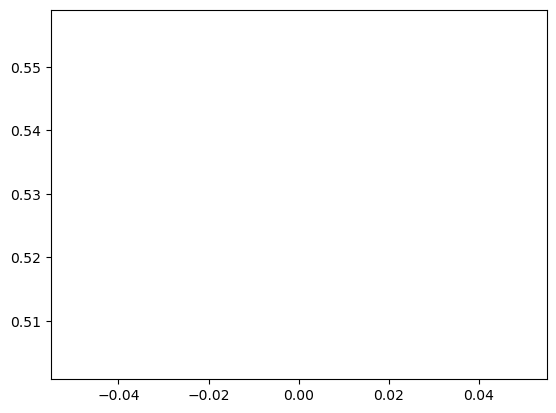

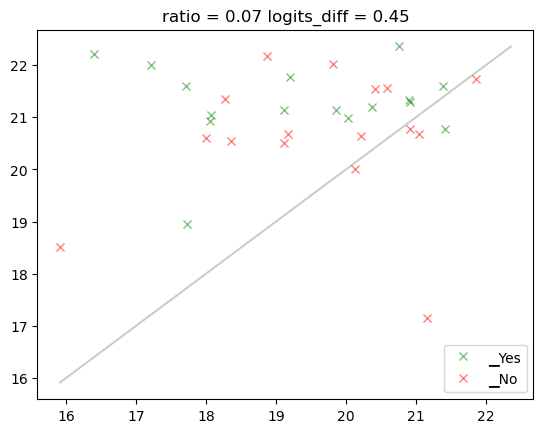

In [51]:
# logger = TeeLogger('predict2.out', 'a')  # logger.__del__()
nrows, k_shot = 1, 0; cxt_len = 3; save_results = False # key is not None
batch_size = 16; verbose = False #not save_results or batch_size <= 8
rel1_kwargs = {'x_f': None}  # {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}
for task,        rel0_i, rel1_i, do_swap_qa, do_negate, do_rm_query, rev_item2str, do_g2c in product(
    # tasks_r[0:1], [0],[0],[False,],  [False, ],[False, ],[False,],['counter_paired']):  # for tasks0 (remove_local_hop)
    # tasks[:1],[0,1],[1,0],[False,True],[False,],[False],[False,True],[False]):  # for tasks (with_local_hop)
    tasks[7:8],[0],[0],[False,],[False,],[False],[False],['counter_paired']):
    # tasks[1:2],[0],[[1, 2]],[False,],[False,],[False],[False,],['counter_paired']):
#     tasks_rlrlr[0:1],[0,],[0],[False,],[False,],[False],[False],[True]):
    seed(42); np.random.seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_i=rel0_i, rel1_i=rel1_i, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_query=do_rm_query, do_g2c=do_g2c)
    task = transform_and_validate_task(task, **trans_args, **args)
#     if task[0]()[1].relations[0].name == 'equal': continue
    if task is None: continue
    res_key = f'{task2str(task)}[{args2str(args)}]'  # {composed_heads2str(model)}
#     if key and res_key != key: continue
    print(f'\n== {res_key} == {args2str(trans_args)}')
    r = results[res_key] if save_results and res_key in results else None
#     if r is not None: print('duplicate task!'); continue
    r, _ = generate_and_predict_batch(model, tokenizer, task, nrows, k_shot, batch_size,
            logits_bias=None, custom_forward=True, result=r,
            counter_paired=do_g2c == 'counter_paired', verbose=verbose, **args)
    if save_results: results[res_key] = r
    elif True or r.mean_acc < 0.6: continue

    if True or r.root is None:
        r.root = node = add_node(None, layer=L, label_type='labels')
    _ = attribute_tree_on(r.data_tuples, model, r.root, 2, filter_fn, topk=15, k_shot=k_shot, threshold_score=0.2,
                          attributed_top_mlps=5, mix=True, device=None, verbose=True)

In [54]:
r.texts

('Premise: < David is irrational. Sharon is reliable. Barbara is rational. >. Answer with Yes or No. Is it possible that Barbara is irrational? Answer: No\n',
 'Premise: < David is irrational. Sharon is reliable. Barbara is rational. >. Answer with Yes or No. Is it possible that Barbara is rational? Answer: Yes\n',
 'Premise: < Betty is interesting. David is quick. Dorothy is introverted. >. Answer with Yes or No. Is it possible that David is sluggish? Answer: No\n',
 'Premise: < Betty is interesting. David is quick. Dorothy is introverted. >. Answer with Yes or No. Is it possible that David is uninteresting? Answer: Yes\n',
 'Premise: < Richard is indecisive. Brian is full. Sarah is powerful. >. Answer with Yes or No. Is it possible that Richard is resolute? Answer: No\n',
 'Premise: < Richard is indecisive. Brian is full. Sarah is powerful. >. Answer with Yes or No. Is it possible that Richard is weak? Answer: Yes\n',
 'Premise: < Christopher is hardworking. Richard is unhealthy. Jas

In [333]:
0.7499721088097431 0.78125 0.67453125  7-shot
1.1725516363221686 0.625 0.593  3-shot
1.647858073192765 0.5625 0.55275  1-shot
1.0376770469592884 0.65625 0.58134375 0-shot

# Is it possible that
0.9510731063783169 0.625 0.5572500000000001 7-shot
1.3694345251715276 0.46875 0.5061249999999999 3-shot
1.1332418613892514 0.5 0.52634375 1-shot
0.6309064640663564 0.6875 0.6236875 0-shot

('Premise: < David is rude. Sharon is kind. Barbara is rational. >. Answer with Yes or No. Can it be inferred from the premise that Barbara is not irrational? Answer: Yes\n',
 'Premise: < David is rude. Sharon is kind. Barbara is rational. >. Answer with Yes or No. Can it be inferred from the premise that Barbara is not courteous? Answer: No\n')

In [ ]:
receiver_heads = [(15, 51)]; cls_label = 'No'; attn_pattern = 'A->Q'
data_tuples = split_data_tuples_by_cls(r.data_tuples)[cls_label]
attrs = {}
for dst_rlabel in ['A', 'Q', 'dA0'][:2]:
    attrs[dst_rlabel] = mr(patch_attribute)(data_tuples, model, dst_rlabel, receiver_heads=receiver_heads, attn_pattern=attn_pattern, k_shot=k_shot)

A


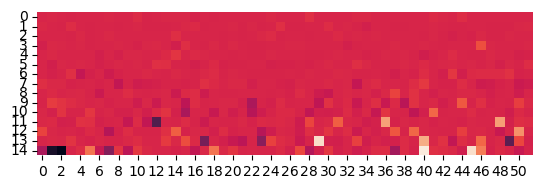

14-40 0.1147 ('A->Q', 0.07736289501190186)
14-45 0.10693 ('A->Q', 0.4112567901611328)
13-29 0.1052 ('A->dA0', 0.5741353034973145)
13-40 0.0743 ('A->Q', 0.4441795349121094)
11-36 0.0681 ('A->dA0', 0.05734333395957947)
11-48 0.06616 ('A->dA0', 0.4166834354400635)
12-50 0.05948 ('A->dA0', 0.6759732365608215)
14-46 0.04794 ('A->Q', 0.09261202812194824)
14-18 0.04276 ('A->dA0', 0.1162884533405304)
14-5 0.04245 ('A->Q', 0.10947513580322266)
Q


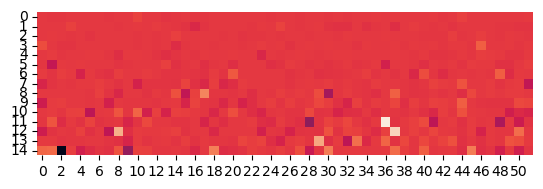

11-36 0.102 ('Q->nA0s+', 0.15489783883094788)
12-37 0.08765 ('Q->Q', 0.4118614196777344)
12-8 0.06384 ('Q->A0', 0.5516560077667236)
13-29 0.05945 ('Q->Q', 0.2233257293701172)
8-17 0.0396 ('Q->T+', 0.5555763244628906)
14-18 0.0361 ('Q->T+', 0.20529937744140625)
14-45 0.0346 ('Q->nA0s+', 0.10840463638305664)
14-30 0.03433 ('Q->Q', 0.13706016540527344)
13-33 0.02786 ('Q->Q', 0.09235477447509766)
12-50 0.02704 ('Q->T', 0.3692188262939453)


In [227]:
for dst_rlabel, a in attrs.items():
    print(dst_rlabel)
    _ = sns.heatmap(a.cpu(), square=True, cbar=False); plt.show()
    for l, h, score in topk_md(a, 10, transpose=True):
        print(f'{l}-{h}', score, match_attn_pattern(data_tuples, l, h, dst_rlabel, k_shot=k_shot))

A


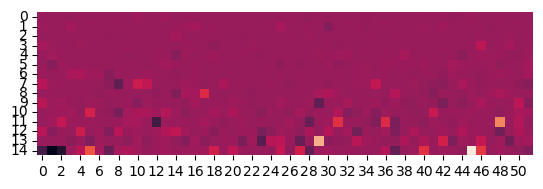

14-45 0.1409 ('A->Q', 0.3939618468284607)
13-29 0.1059 ('A->dA0', 0.13284754753112793)
11-48 0.0834 ('A->dA0', 0.12427830696105957)
14-5 0.05957 ('A->Q', 0.19652676582336426)
14-46 0.04578 ('A->Q', 0.127914160490036)
11-31 0.04266 ('A->dA0', 0.03852201998233795)
14-40 0.04227 ('A->Q', 0.033447861671447754)
8-17 0.03818 ('A->dA0', 0.04234278202056885)
11-36 0.03763 ('A->dA0', 0.023933619260787964)
10-5 0.03287 ('A->dA0', 0.058332040905952454)
Q


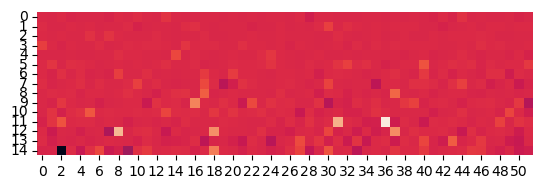

11-36 0.1511 ('Q->nTs', 0.09979648143053055)
12-8 0.10657 ('Q->A0+', 0.12244901061058044)
11-31 0.1001 ('Q->nTs', 0.18264040350914001)
12-18 0.0753 ('Q->A0+', 0.09045293927192688)
12-37 0.07294 ('Q->Q', 0.3472728729248047)
9-16 0.0651 ('Q->T', 0.5226724147796631)
14-18 0.06058 ('Q->T+', 0.15865248441696167)
8-37 0.04443 ('Q->T', 0.6170473098754883)
8-17 0.03928 ('Q->T+', 0.382904052734375)
13-43 0.0373 ('Q->Q-', 0.39485931396484375)


In [240]:
for dst_rlabel, a in attrs.items(): # sweater is owned by Kenneth? 
    print(dst_rlabel)
    _ = sns.heatmap(a.cpu(), square=True, cbar=False); plt.show()
    for l, h, score in topk_md(a, 10, transpose=True):
        print(f'{l}-{h}', score, match_attn_pattern(data_tuples, l, h, dst_rlabel, k_shot=k_shot))

A


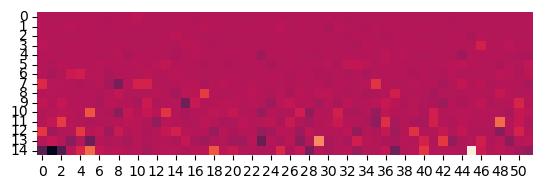

14-45 0.177 ('A->Q', 0.3789348602294922)
13-29 0.10034 ('A->dA0', 0.1971120834350586)
14-5 0.07874 ('A->Q', 0.18953609466552734)
11-48 0.07764 ('A->dA0', 0.1802436113357544)
14-18 0.06433 ('A->Q', 0.026223182678222656)
10-5 0.06335 ('A->dA0', 0.058476321399211884)
11-2 0.0473 ('A->dA0', 0.16040253639221191)
8-17 0.04715 ('A->dA0', 0.03358694911003113)
12-4 0.04547 ('A->Q', 0.42875003814697266)
13-42 0.04434 ('A->Q', 0.34177303314208984)
Q


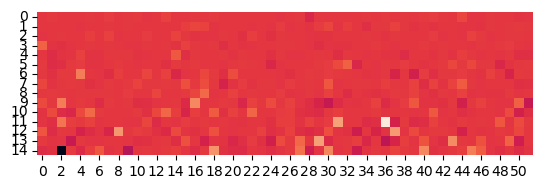

11-36 0.1721 ('Q->nTs', 0.09360373765230179)
11-31 0.095 ('Q->nTs', 0.14209292829036713)
13-29 0.09344 ('Q->T', 0.2937906086444855)
12-37 0.0883 ('Q->Q', 0.3262519836425781)
12-8 0.08496 ('Q->A0+', 0.1343902349472046)
14-18 0.0818 ('Q->T+', 0.13504940271377563)
13-43 0.07263 ('Q->Q', 0.13724589347839355)
9-16 0.06995 ('Q->T', 0.4475225806236267)
14-40 0.0697 ('Q->A0+', 0.10077857971191406)
14-30 0.0684 ('Q->Q', 0.17804360389709473)


In [244]:
for dst_rlabel, a in attrs.items(): # the one who owns sweater is Kenneth?
    print(dst_rlabel)
    _ = sns.heatmap(a.cpu(), square=True, cbar=False); plt.show()
    for l, h, score in topk_md(a, 10, transpose=True):
        print(f'{l}-{h}', score, match_attn_pattern(data_tuples, l, h, dst_rlabel, k_shot=k_shot))

In [186]:
all_attrs = {}

In [ ]:
dst_rlabel = 'A'
all_outputs = None #[dt[-1] for dt in r.data_tuples]
attrs = defaultdict(dict)
for cls_label, data_tuples in split_data_tuples_by_cls(r.data_tuples).items():
    attrs[dst_rlabel][cls_label] = mr(patch_attribute)(data_tuples, model, dst_rlabel, all_outputs=all_outputs, to_layer=20)
all_attrs[res_key] = attrs

g2c[rlr_gen][kinds_of_things.TreeSet.equal,kinds_of_things.TreeSet.child][cxt_len=1]
('Answer with Yes or No. Is sweater a kind of clothing? Answer: Yes\n',
 'Answer with Yes or No. Is sweater a kind of weapon? Answer: No\n')


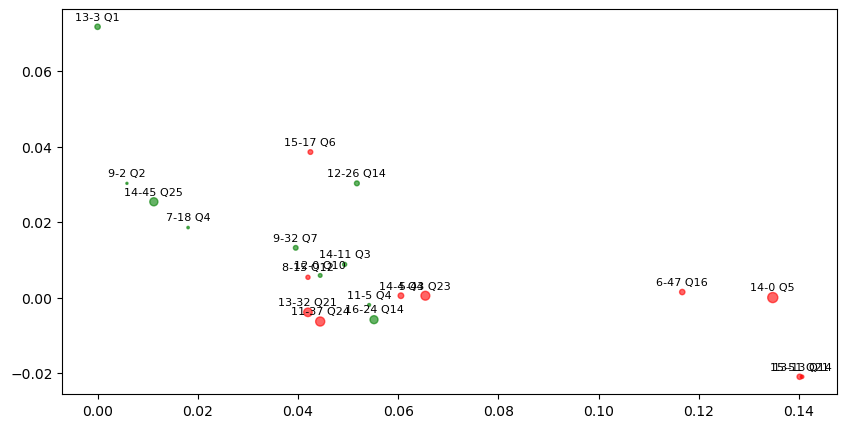

,head_label,sum_attr,yes_attr,no_attr,yes_ap,yes_ap_score,no_ap,no_ap_score,head_type,daw
0,14-0 Q5,0.134766,0.000000,0.134766,A->Q,0.031480,A->Q,0.052944,No,-0.211973
1,13-13 Q14,0.119629,-0.020996,0.140625,A->Q,0.107545,A->Q,0.140815,No,-0.024493
2,15-51 Q21,0.119141,-0.020996,0.140137,A->Q,0.122168,A->Q,0.214214,No,-0.058037
3,6-47 Q16,0.118164,0.001465,0.116699,A->Q,0.097907,A->Q,0.162262,No,-0.059550
4,12-26 Q14,0.082031,0.030273,0.051758,A->Q,0.139490,A->Q,0.082416,Yes,0.048981
5,15-17 Q6,0.081055,0.038574,0.042480,A->Q,0.042068,A->Q,0.058837,No,-0.046196
6,13-3 Q1,0.071777,0.071777,0.000000,A->Q,0.013795,A->Q,0.011459,Yes,0.060322
7,5-43 Q23,0.065918,0.000488,0.065430,A->Q,0.055832,A->Q,0.229521,No,-0.163209
8,14-4 Q4,0.061035,0.000488,0.060547,A->Q,0.044431,A->Q,0.040014,No,-0.065163
9,14-11 Q3,0.058105,0.008789,0.049316,A->Q,0.034277,A->Q,0.024807,Yes,0.034716


In [344]:
print(res_key); pprint(r.texts[:2])
daws = get_attn_weight_diffs(r.data_tuples, dst_rlabel)
pd.DataFrame(plot_yes_no_heads(r.data_tuples, attrs[dst_rlabel]['Yes'], attrs[dst_rlabel]['No'], daws, dst_range_label))

In [ ]:
print(res_key); pprint(r.texts[:2])
daws = get_attn_weight_diffs(r.data_tuples, dst_rlabel)
plot_yes_no_heads(attrs[dst_rlabel]['Yes'], attrs[dst_rlabel]['No'], daws)

g2c[rlr_gen[dict_candidates=True]][genders_of_persons.TreeSet.equal,kinds_of_things.TreeSet.child][cxt_len=3]
('Premise: < David has rabbit. Sharon has jacket. Barbara has bread. >. Answer '
 'with Yes or No. Can it be inferred from the premise that Barbara owns a kind '
 'of food? Answer: Yes\n',
 'Premise: < David has rabbit. Sharon has jacket. Barbara has bread. >. Answer '
 'with Yes or No. Can it be inferred from the premise that Barbara owns a kind '
 'of animal? Answer: No\n')


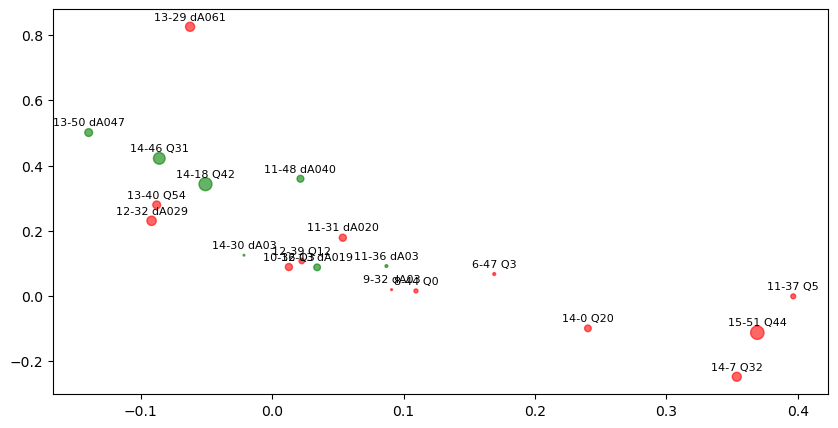

,head_label,sum_attr,yes_attr,no_attr,yes_ap,yes_ap_score,no_ap,no_ap_score,head_type,daw
0,13-29 dA061,0.762695,0.825195,-0.062500,A->dA0,0.651475,A->dA0,0.605988,No,-0.172722
1,11-37 Q5,0.395508,-0.000977,0.396484,A->Q,0.048710,A->Q,0.046728,No,-0.049321
2,11-48 dA040,0.380859,0.359375,0.021484,A->dA0,0.403171,A->dA0,0.197863,Yes,0.098010
3,13-50 dA047,0.361328,0.500977,-0.139648,A->dA0,0.469882,A->dA0,0.308492,Yes,0.126634
4,14-46 Q31,0.335938,0.421875,-0.085938,A->Q,0.308350,A->Q,0.049307,Yes,0.281317
5,14-18 Q42,0.291992,0.342773,-0.050781,A->Q,0.418739,A->dA0,0.122834,Yes,0.349995
6,15-51 Q44,0.256836,-0.112305,0.369141,A->Q,0.083595,A->Q,0.437317,No,-0.373779
7,6-47 Q3,0.236328,0.067383,0.168945,A->dA0,0.030208,A->Q,0.030997,No,-0.017442
8,11-31 dA020,0.232422,0.178711,0.053711,A->dA0,0.205976,A->dA0,0.197696,No,-0.104355
9,13-40 Q54,0.191406,0.279297,-0.087891,A->Q,0.395035,A->Q,0.536530,No,-0.127619


In [350]:
print(res_key); pprint(r.texts[:2])
daws = get_attn_weight_diffs(r.data_tuples, dst_rlabel)
pd.DataFrame(plot_yes_no_heads(r.data_tuples, attrs[dst_rlabel]['Yes'], attrs[dst_rlabel]['No'], daws, dst_rlabel))

In [ ]:
layer, head = 14, 18
width = 5 * 2; rows = len(r.data_tuples) // 2 // 2
_, axs = plt.subplots(rows, 2, figsize=(width * 2, width * rows))
for (text, input_ids, labels, ranges, *_, o), ax in zip(r.data_tuples, axs.flatten()):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    a = o.attentions[layer][0, head]
    y_pos = list(range(*get_range(ranges[-1], restore_attn_pattern('A'))))
    x_pos = list(range(*get_range(ranges[-1], restore_attn_pattern('Q'))))
    _ = _plot_attn(a, tokens=tokens, y_pos=y_pos, x_pos=x_pos, figsize=(5, 5), fontsize=9, ax=ax)

In [504]:
print_tree(r.root)

 ┌@[0,1,3,4,7,8] 44-m,45-m,25-m,59-m,29-22 21,36-m 21 B->B 57
 ├@[5] 35-35 B->A+ 6
 ├@[2,6] 32-21,39-40 28 unk 0
 ├@0 44-m 100
 ├@1 45-m 66
 ├@3 25-m 44
 ├@4 59-m 39
 ├@7 29-22 21 B->B 40/30
 ├@8 36-m 21
 ├@5 35-35 33 B->A+ 63/33
 ├@2 32-21 48 B->A] 55/45
 ├@6 39-40 28 B->A0 0/3
 ┤
 │         ┌@[1,3,4,5,6,7,8] 34-m,24-m,22-m,29-22,28-m,36-26 29,20-m 27 B->B 42
 │         ├@[2,9] 18-22,24-47 25 B->A+ 22
 │         ├@[0] 32-21 B->A] 5
 │         ├@1 34-m 59
 │         ├@3 24-m 42
 │         ├@4 22-m 37
 │         ├@5 29-22 36 B->B 36/30
 │         ├@6 28-m 32
 │         ├@7 36-26 29 B->B 7/4
 │         ├@8 20-m 27
 │         ├@2 18-22 48 B->A+ 85/83
 │         ├@9 24-47 25 B->A+ 84/70
 │         ├@0 32-21 100 B->A] 60/45
 └36-m B->B┤
           │           ┌@:15 14-m,15-m,17-m,12-m,20-m,17-40,26-m,28-m 29,21-9 25,27-m 25,8-m 25,24-m 24,25-m 24,11-m 23,10-m 22 A]->A] 88
           │           ├@0 14-m 100
           │           ├@1 15-m 94
           │           ├@2 17-m 52
           │  

In [ ]:
layer = 20
YNs, hiddens = [], []
for text, input_ids, labels, ranges, *_, o in r.data_tuples:
    YN = 'g' if text.strip().endswith('Yes') else 'r'
    gate = o.mlp_gates[layer][0, ranges[1].ans[1] + 1 - 1]
    pre_act = o.mlp_pre_acts[layer][0, ranges[1].ans[1] + 1 - 1]
    YNs.append(YN)
    hiddens.append((pre_act).numpy())
hiddens = np.array(hiddens)
fisher_discriminant_ratio(YNs, hiddens, labels=['g', 'r'], plot=False)
visualize_by_pca(hiddens, YNs)

In [481]:
mask_neurons={44: 3504, 36: 14120, 25: 5507, 20: 5080, 21: 8322, 12: 9483, 19: [6387, 5351], 15: 5657}
layer, range_label = [(44, 'B'), (36, 'B'), (25, 'B'), (21, 'A+'), (20, 'B'), (15, 'A')][-1]
average_activations(r.data_tuples, layer, range_label, neuron_idx=mask_neurons[layer])

In [480]:
remove_avg_activations(r.data_tuples, 15)

In [495]:
node = r.root.children[-1].children[-1].children[-1].children[-1]#.children[-1]#.children[-1]#.children[-1]
node.name

'11-m A]->A]'

36-m B->B ag -> 32-21 B->A] -> 14-m,15-m A]->A] -> 11-m A]->A] -> 5-43 + 7-39
gx [-1.3242188  -1.3818359   1.421875   -1.3447266  -1.1806641  -1.3242188
 -1.3525391  -1.2919922  -1.3164062  -0.9472656  -1.2539062  -1.3857422
 -1.421875   -1.2939453  -1.4589844  -1.1806641  -1.2841797  -1.2949219
 -1.3867188  -0.44262695]
rx [-1.3447266 -1.4287109 -1.5898438 -0.6977539 -1.4833984 -1.2949219
 -1.6025391 -1.3369141 -1.4023438 -1.5527344  1.5507812 -1.453125 ]


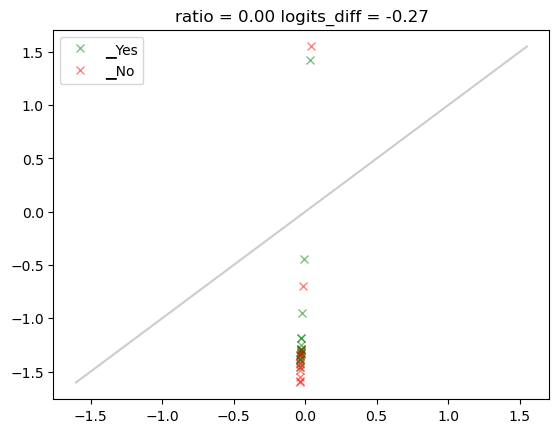

reduced_ap_scores = tensor([1.0244], device='cuda:0', dtype=torch.float16) tensor(1.0244, device='cuda:0', dtype=torch.float16)


In [497]:
# for cls_label, data_tuples in split_data_tuples_by_cls(r.data_tuples[:16]).items():
for data_tuples in [r.data_tuples[:]]:
    plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0,4], attn_patterns=['B->A+'], k_shot=k_shot, mix=True)

In [423]:
topk_md(get_head_mlp_attr(node.data.attr), 10)

(array([15, 15, 14, 11, 14, 15,  9, 16,  7, 16]),
 array([52, 51,  1, 52, 46, 49, 52, 24, 52, 13]),
 array([7.35415146e-04, 2.74766237e-04, 1.14372000e-04, 1.06185675e-04,
        1.02911144e-04, 1.02246180e-04, 9.59876925e-05, 9.10721719e-05,
        8.95019621e-05, 7.28592277e-05], dtype=float32))

In [177]:
node_key = node2key(node); node_key
mr(get_head_matching_scores)(r.data_tuples, ap, node_key=node_key, k_shot=k_shot)

'29-3 > 19-24,18-18 attn > 17-32,17-28 attn'

{(16, 51): tensor(0.),
 (16, 10): tensor(0.),
 (15, 4): tensor(0.),
 (15, 51): tensor(0.),
 (12, 18): tensor(0.),
 (11, 1): tensor(0.)}

In [202]:
text, input_ids, labels, ranges, *args, o = r.data_tuples[-8]
attn_labels, ranges_q = attn_pattern2labels(ranges, ap, o.attentions[0].size()[-2:], k_shot=k_shot)

In [196]:
layer, head = 14, 18
pd = node.data
{ap: v[layer, head].item() for ap, v in pd.attr_ap_scores.items()}

{'ans]->ans0]': 0.0,
 'ans]->ans0+': 0.0,
 'ans]->ans-': 0.0,
 'ans]->query': 0.0,
 'ans]->ans+^': 0.0,
 'ans]->query+': 0.0,
 'ans]->query|query+': 0.0,
 'ans]->bos^': 0.0,
 'ans]->ntgts+': 0.0,
 'ans]->nans0s': 0.0,
 'ans]->ans]': 0.0}

In [318]:
# node.data.base_layer, node.data.base_head = tuple(map(list, (zip(*[(16,14),(16, 39), (14, 18), (14, 46)]))))
node.data.base_layer, node.data.base_head = tuple(map(list, (zip(*[(16,14),(16, 39), (13, 50)]))))
# nodes.append(node)

In [404]:
node.data.mask_patterns = {(18,22): 'A+->A]|A+', (19,2): 'A+->A]|A+',}  # 19-m

In [108]:
# we = to(model.transformer.wte.weight.data, 'cpu')
# wu = to(model.lm_head.weight.data, 'cpu')
we = model.transformer.wte.weight.data
wu = model.lm_head.weight.data

es = [we]
for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1])[0])

In [111]:
layer, head = 36, 26
wq, wk, wv, wo = get_head_weights(model, layer, head, transpose=True)
e = blocks[layer].ln_1(es[1])

qk = False
if qk:
    # e @ wq @ wk @ e
    A, B = e @ wq, e @ wk
    m = A @ B.T
else:
    # @ wv @ wo @ wu.T
    A, B = wu @ wo.T, e @ wv  #  wu, ln_f(e @ wv @ wo)  # slow for eig
    m = wu @ ln_f(B @ wo).T  # a little better than A @ B.T
plot_eigv(torch.linalg.eig(to(B.T @ A, 'cpu'))[0])

RuntimeError: This function was deprecated since version 1.9 and is now removed. Please use the `torch.linalg.eig` function instead.

In [ ]:
plot_eigv(torch.linalg.eig(to(B.T @ A, 'cpu'))[0])

In [139]:
lookup_top_entries(tokenizer, m, 'yes')

{'▁yes': 54,
 '▁Yes': 53,
 '▁no': 53,
 'Yes': 52,
 '▁No': 52,
 'No': 52,
 '▁YES': 51,
 '▁NO': 49,
 'no': 48,
 'YES': 46,
 'yes': 46,
 'NO': 45,
 '▁ano': 34,
 '▁Kno': 32,
 '▁yeah': 31,
 'nof': 31,
 'nos': 31,
 '▁Ye': 31,
 '▁não': 31,
 '▁nos': 29}

In [88]:
node = r.root.children[-4].children[-1]; node.name

'11-12,9-5 B->Q attn:B->~<s>'

In [ ]:
plot_attn_attrs(r.data_tuples[:1], model, tokenizer, node, topi=[1], attn_patterns=['B->B'], k_shot=k_shot+4, mix=False)

In [ ]:
for data_tuple in data_tuples[:3]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 13, 7, attn_patterns=['bos->ans0]'], k_shot=0, plot_attr=False)

In [ ]:
node = node.parent

In [ ]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2,3,4])#layer=11, head=12, attn_pattern='bos->query]', label_type='argmax_attn_labels')

In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.child) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:3]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 13, 7, attn_patterns=['bos->ans0]'], k_shot=0, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=False)

In [ ]:
node = result.root

In [ ]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2])#, attn_pattern='bos->query]', label_type='argmax_attn_labels')

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])#attn_pattern='bos->ans0]', label_type='argmax_attn_labels')

In [ ]:
key = 'MlM_gen(genders_of_persons.TreeSet.equal, types_of_things.TreeSet.equal) (cxt_len=3)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:]:
    plot_attn_attr(data_tuple, model, tokenizer, node, 11, 12, attn_patterns=['bos->query]'], k_shot=0, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1], k_shot=k_shot)

In [ ]:
node = result.root

In [ ]:
print(key); print('\n'.join(result.texts[-1].split('\n')[:1]))
node = result.node = add_node(node, topi=[0,1,2,3,4,5])#, label_type='argmax_attn_labels')

In [ ]:
print(key); node = result.node = add_node(node, topi=[0])#, attn_pattern='bos->query]', label_type='argmax_attn_labels')

In [ ]:
for head_chain in product([(8, 7), (6, 2)], [(13, 13), (9, 14), (12, 10)], [(16, 7)]):
    print(head_chain, plot_eigv(weightprod(model, list(head_chain), 'e vo vo qk e', weBTA=model.weBTAs[0]), plot=False))

### person_adjs.opposite

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6/6-10->4-8_1-7/6-2/8-7->7-9'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:3], model, tokenizer, node, topi=[0,1,2], k_shot=k_shot, mix=False)

In [ ]:
node = result.root

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1])#, label_type='argmax_attn_labels')

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)_4-6qk->4-8_6-2qk->7-9'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3]) #label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
node = node.parent

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1], head_attr_fn=get_head_mlp_attr)#label_type='argmax_attn_labels', attn_pattern='bos->query]') # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=3, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,4,5], k_shot=k_shot)  # 

In [ ]:
forked_node_k.k_node = q_node; forked_node_k.model = model
del forked_node_k.k_node; del forked_node_k.model

In [ ]:
forked_node.k_node = k_node; forked_node.model = model
del forked_node.k_node; del forked_node.model

In [ ]:
node = node.parent.parent

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3]) #label_type='attn_labels', attn_pattern='bos->query]', step=0, attribute_k=True) # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)  # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr, 

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,2], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot, mix=True)  # 

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 7, 9, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [ ]:
node = node.children[1]

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2], head_attr_fn=get_head_mlp_attr)# label_type='attn_labels')  # 

### thing->type

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [ ]:
node.name

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,2,4], head_attr_fn=get_head_mlp_attr)#, label_type='argmax_attn_labels')  # 

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for data_tuple in data_tuples[:4]: plot_attn_attr(data_tuple, model, tokenizer, node, 16, 7, attn_patterns=['bos->ans0]'], k_shot=k_shot, plot_attr=False)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0,1,2,3], head_attr_fn=get_head_mlp_attr, k_shot=k_shot)

In [ ]:
node = node.parent.parent

In [ ]:
print(key); node = result.node = add_node(node, layer=16, head=7, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')  # 

In [ ]:
print(key); node = result.node = add_node(node, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')

### fr->en

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0,1,2], k_shot=k_shot)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2], label_type='argmax_attn_labels')  # head_attr_fn=get_head_mlp_attr

In [ ]:
analyze_head_chains(model, get_head2scores(result.root.children[1].children[0].children[0]))

### did->does

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0,1], head_attr_fn=get_head_mlp_attr, mix=True)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    show_predictions(tokenizer, *args, logits=o.logits, labels=labels, k_shot=k_shot, topk=3)[0]

In [ ]:
result.node = result.node.parent.parent.parent
result.node = result.root

In [ ]:
print(key); node = add_node_to_result(result, topi=[1,0,2,7], head_attr_fn=get_head_mlp_attr, label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr

In [ ]:
for data_tuple in data_tuples:
    plot_attn_attr(data_tuple, model, tokenizer, node, 17, 16, attn_patterns=None, k_shot=0, plot_attr=False)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node.parent, topi=[0,1,6,7,10])

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=10)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 7], head_attr_fn=get_head_mlp_attr)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3], label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr, 

### thing->capability

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1])

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[2,1,3,0])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
        tokenizer, *args, logits=o.logits, labels=labels, loss_reduction='mean',
        candidates=None, k_shot=k_shot, topk=3, verbose=True)
    print(loss)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0], k_shot=k_shot)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2, 3], k_shot=k_shot, plot_attr=False)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1,2,0], label_type='argmax_attn_labels')

### capital->country

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
print(key); node = add_node_to_result(result, topi=[0])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='argmax_attn_labels')

### person_adjs.opposite

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3,4])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,])#, label_type='attn_labels')

### thing->type

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")  # old full

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1, 2])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

In [ ]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

In [ ]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [ ]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

In [ ]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [ ]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [ ]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [ ]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [ ]:
get_prob_dist(logits.top_logprobs[-1], 5)

In [ ]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [ ]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

In [ ]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [ ]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

In [ ]:
sum(s.count('Yes') for s in input_strs)

In [ ]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [ ]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [ ]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [ ]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [ ]:
trainer.place_model_on_device

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [ ]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])